### Libraries

In [16]:
import os
import cv2  # OpenCV for image processing
import numpy as np  # For numerical operations
import pandas as pd  # For CSV handling
import matplotlib.pyplot as plt  # For displaying images
# For building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score

### CSV Files

In [17]:
# Dataset images' path and labels were written in csv files
training_csv = r'.\training.csv'
testing_csv = r'.\testing.csv'

### Preprocessing

In [18]:
# Segmentation function 
def segment_eye(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    threshold_img = cv2.adaptiveThreshold(
        blurred_img, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 
        11, 2
    )
    kernel = np.ones((3, 3), np.uint8)
    segmented_img = cv2.dilate(threshold_img, kernel, iterations=2)
    return segmented_img

# Blur the background 
def blur_background(img, segmented_img):
    blurred_background = cv2.GaussianBlur(img, (21, 21), 0)
    result = np.where(segmented_img[..., None] == 255, img, blurred_background)
    return result

# Highlight cloudiness
def highlight_cloudiness(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, white_areas = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    highlighted = cv2.addWeighted(img, 1, cv2.cvtColor(white_areas, cv2.COLOR_GRAY2BGR), 0.5, 0)
    return highlighted

# Remove reflections 
def remove_reflections(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, reflections = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY)
    reflection_removed = cv2.inpaint(img, reflections, 3, cv2.INPAINT_TELEA)
    return reflection_removed

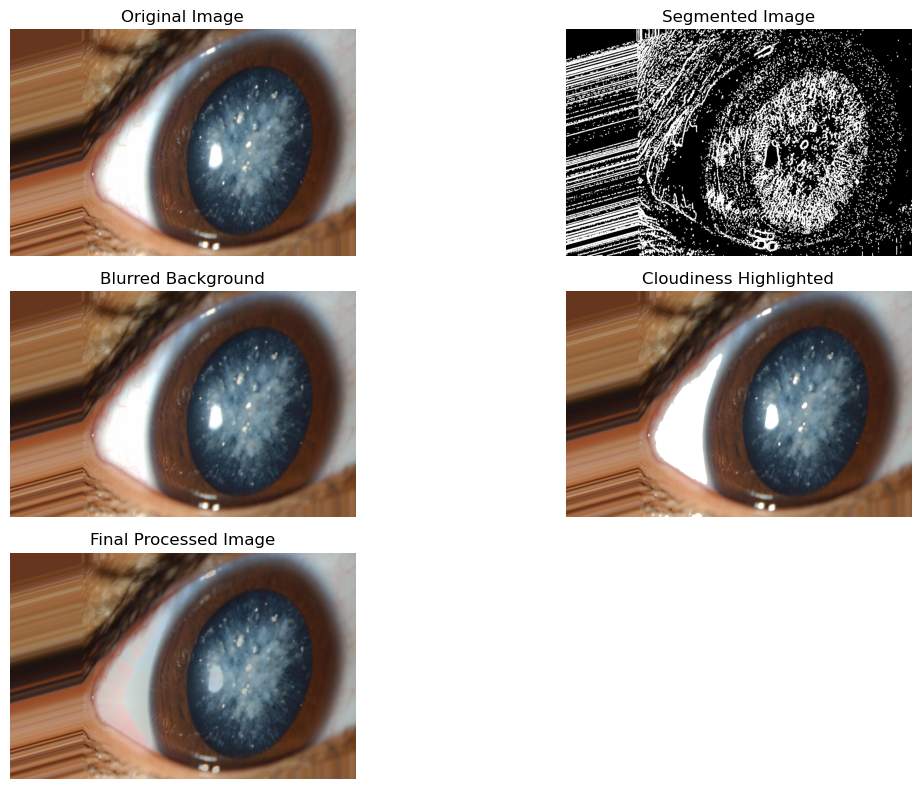

In [19]:
# Displaying the images to show the results of the preprocessing

def display_images(images, titles):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(3, 2, i + 1)  
        if len(images[i].shape) == 2:  
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)) 
        plt.title(titles[i])
        plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()


# Full preprocessing pipeline with error handling
def preprocess_pipeline(image_path):
    # Loading the image
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Error: Could not load image at {image_path}. Please check the file path.")
    
    # Segmentation
    segmented_image = segment_eye(image)
    
    # Bluring the background
    blurred_background = blur_background(image, segmented_image)
    
    # Highlighting cloudiness
    highlighted_cloudiness = highlight_cloudiness(blurred_background)
    
    # Removing reflections
    final_image = remove_reflections(highlighted_cloudiness)
    
    # Display the images
    images = [image, segmented_image, blurred_background, highlighted_cloudiness, final_image]
    titles = ['Original Image', 'Segmented Image', 'Blurred Background', 'Cloudiness Highlighted', 'Final Processed Image']
    display_images(images, titles)
    
    return final_image

# Displaying one image only
image_path = 'dataset/Train/Cataract/cat_0_1781.jpg'
final_result = preprocess_pipeline(image_path)

In [20]:
# Preprocessing class
class CataractDataPreprocessor:
    def __init__(self, csv_file, target_size=(128, 128)):
        self.csv_file = csv_file
        self.target_size = target_size
        self.image_paths, self.labels = self.load_data()

    # Load the CSV file
    def load_data(self):
        data = pd.read_csv(self.csv_file)
        image_paths = data['ImagePath'].values
        labels = data['Label'].values
        return image_paths, labels

    # Preprocess images by applying all image enhancement 
    def preprocess_images(self):
        images = []
        
        for path in self.image_paths:
            img = cv2.imread(path)
            
            if img is not None:
            
                segmented_img = segment_eye(img)
                img = blur_background(img, segmented_img)
                img = highlight_cloudiness(img)
                img = remove_reflections(img)
                
                # Resize the image to the target size
                img_resized = cv2.resize(img, self.target_size)
                images.append(img_resized)
            else:
                print(f"Warning: Image {path} could not be loaded.")
        
        # Convert to a NumPy array
        images = np.array(images)
        return images

    # Method to return images and labels
    def get_preprocessed_data(self):
        images_resized = self.preprocess_images()
        return images_resized, self.labels


### The CNN Model

In [21]:
# Defining the CNN architecture
def create_cnn_model(input_shape):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth Convolutional Block
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())

    # Fully Connected Layer with Dropout
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer for binary classification (Cataract/Normal)
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with custom learning rate
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [22]:
# Creating the model instance
input_shape = (128, 128, 3)  
model = create_cnn_model(input_shape) 
# Summary of the model
model.summary()

c:\Users\shaik\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,385 (1.74 MB)

 Trainable params: 455,425 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

#### Training

In [31]:
# Preprocessing the training images
preprocessor = CataractDataPreprocessor(training_csv)
# Get the preprocessed images and labels
images_resized, labels = preprocessor.get_preprocessed_data()

# Convert labels to binary 
label_mapping = {'Normal': 0, 'Cataract': 1}
labels = np.array([label_mapping[label] for label in labels])

# Split data into training and validation sets --> 80% Training, 20% Validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images_resized, labels, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Epoch 1/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 756ms/step - accuracy: 0.9896 - loss: 0.0278 - val_accuracy: 0.9690 - val_loss: 0.1110
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 77s 765ms/step - accuracy: 0.9974 - loss: 0.0088 - val_accuracy: 0.9932 - val_loss: 0.0281
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 77s 764ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9969 - val_loss: 0.0164
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 81s 752ms/step - accuracy: 0.9995 - loss: 0.0015 - val_accuracy: 0.9857 - val_loss: 0.0532
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 748ms/step - accuracy: 0.9987 - loss: 0.0037 - val_accuracy: 0.9913 - val_loss: 0.0350
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 757ms/step - accuracy: 0.9990 - loss: 0.0026 - val_accuracy: 0.9957 - val_loss: 0.0126
Epoch 7/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 754ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.9641 - val_loss: 0.0969
Epoch 8/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 88s 870ms/step - accuracy: 0.9991 - loss: 0

#### Testing

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
Accuracy: 97.00%
Precision: 1.00
Recall: 0.94
F1 Score: 0.97


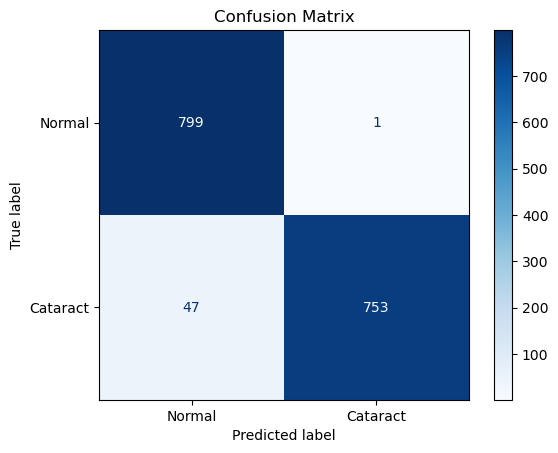

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97       800
    Cataract       1.00      0.94      0.97       800

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600



In [32]:
# Loading Testing Data
def load_test_data(csv_file, image_size=(128, 128)):

    data = pd.read_csv(csv_file)
    image_paths = data['ImagePath'].values
    true_labels = data['Label'].values
    
    label_mapping = {'Normal': 0, 'Cataract': 1}
    true_labels = np.array([label_mapping[label] for label in true_labels])

    # Preprocess the testing images
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img_resized = cv2.resize(img, image_size)
        images.append(img_resized)
    
    images = np.array(images)
    return images, true_labels

# Predicting
def predict_and_evaluate(model, test_images, true_labels):
    # Make predictions
    predictions = model.predict(test_images)
    
    # Convert predictions to binary (0 or 1) for binary classification
    predicted_labels = (predictions > 0.5).astype("int32")
    
    # Metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Cataract'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Cataract']))
    
    return predicted_labels

test_images, true_labels = load_test_data(testing_csv)

# Predict and evaluate
predicted_labels = predict_and_evaluate(model, test_images, true_labels)


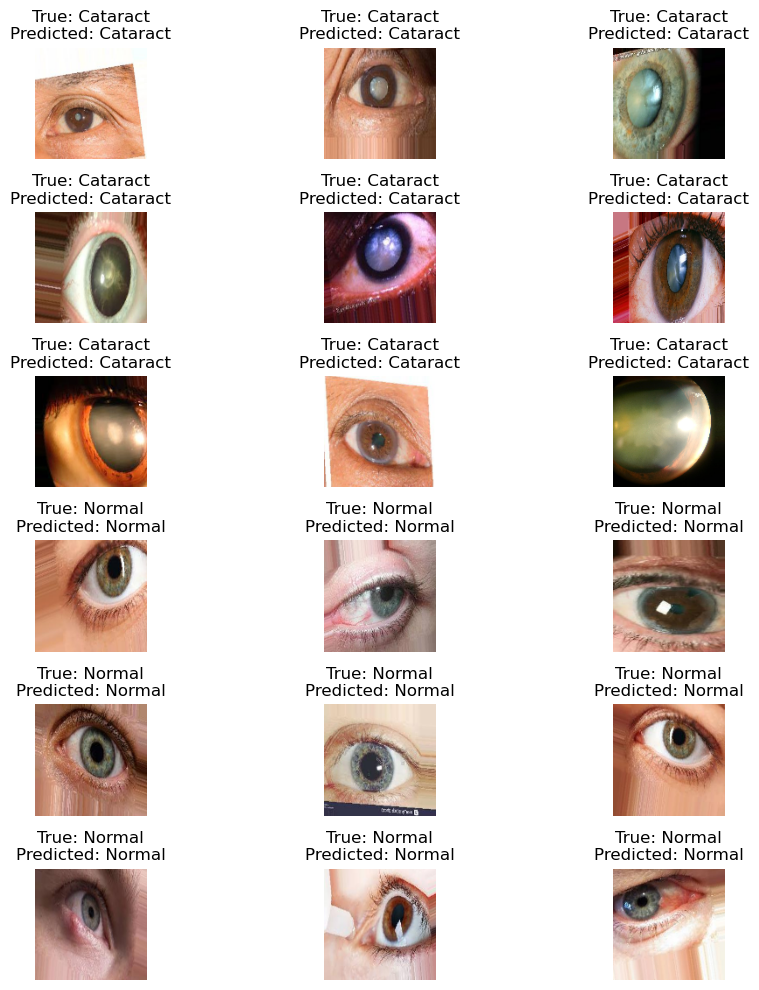

In [33]:
# Visualizing the Predictions for Cataract and Normal
def visualize_predictions(test_images, true_labels, predicted_labels, label_mapping={0: 'Normal', 1: 'Cataract'}):
    plt.figure(figsize=(10, 10))
    
    # Filter for Cataract (1) and Normal (0)
    cataract_indices = [i for i, label in enumerate(true_labels) if label == 1][:9]
    normal_indices = [i for i, label in enumerate(true_labels) if label == 0][:9]
    
    # Select 9 images for each category
    selected_indices = cataract_indices + normal_indices
    selected_images = [test_images[i] for i in selected_indices]
    selected_true_labels = [true_labels[i] for i in selected_indices]
    selected_predicted_labels = [predicted_labels[i] for i in selected_indices]
    
    for i in range(len(selected_images)): 
        plt.subplot(6, 3, i + 1)
        plt.imshow(cv2.cvtColor(selected_images[i], cv2.COLOR_BGR2RGB))
        true_label = label_mapping[selected_true_labels[i]]
        predicted_label = label_mapping[selected_predicted_labels[i][0]]
        
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(test_images, true_labels, predicted_labels)


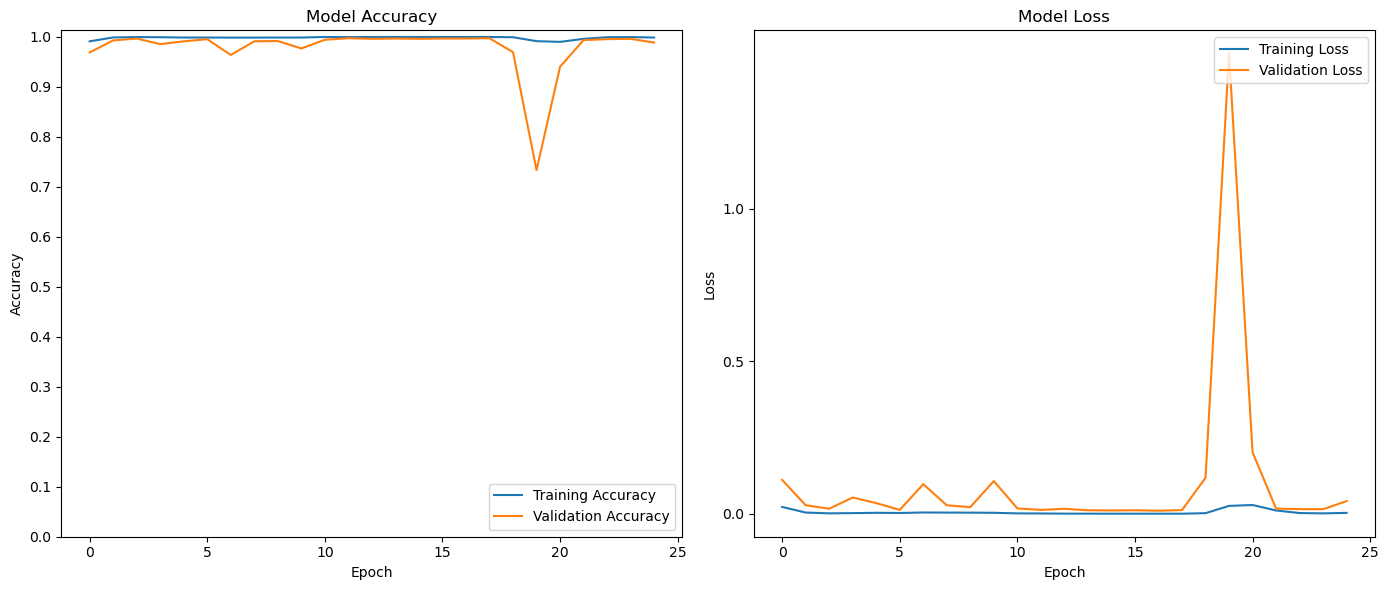

In [34]:
# Plotting Accuracy and Loss
plt.figure(figsize=(14, 6))

# Subplot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(rotation=0)  
plt.yticks(np.arange(0, 1.1, step=0.1))  
plt.legend(loc='lower right')

# Subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(rotation=0)  
plt.yticks(np.arange(0, max(history.history['loss']) + 1, step=0.5))  
plt.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()
